## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SimClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SimClassifier
clf = SimClassifier(method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=10, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Logit Function

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 1 / (1 + np.exp(-(np.dot(x, beta)))) + 0.1 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y <= 0] = 0
y[y > 0] = 1

The best hyperparameter combination can be selected via cross-validation

In [3]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  90 | elapsed:   14.2s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  55 out of  90 | elapsed:   34.9s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.3s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


NameError: name 'shape_fit_' is not defined

In [4]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.1, 'reg_lambda': 0.1}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=0.1, reg_lambda=0.1)

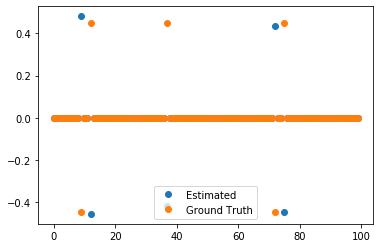

In [6]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

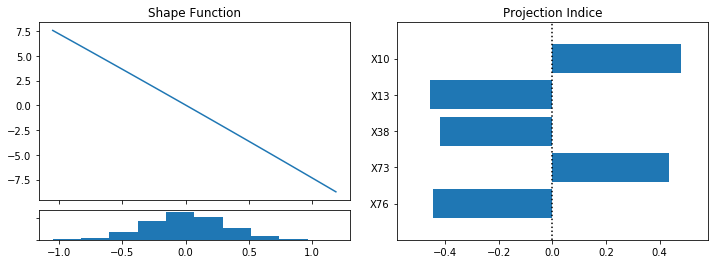

In [7]:
grid.best_estimator_.visualize()

In [8]:
roc_auc_score(y, grid.predict_proba(x))

0.7765308080015347

## Case 2: Quadratic Ridge Function

In [9]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [10]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  90 | elapsed:   16.9s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  55 out of  90 | elapsed:   27.0s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.6s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


NameError: name 'shape_fit_' is not defined

In [11]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.1, 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [12]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=0.1, reg_lambda=0.1)

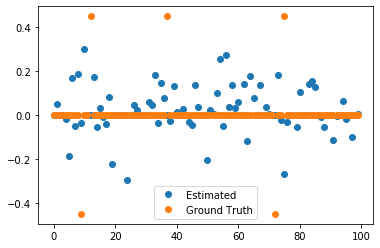

In [13]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

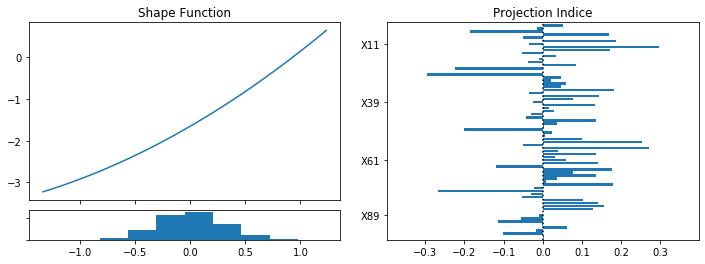

In [14]:
grid.best_estimator_.visualize()

## Case 3: Improve a rough estimator via inner update

In [15]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [16]:
%%time 

clf = SimClassifier(degree=2, knot_num=20, reg_lambda=0.2, reg_gamma=1, random_state=0)
clf.fit(x, y)

NameError: name 'shape_fit_' is not defined

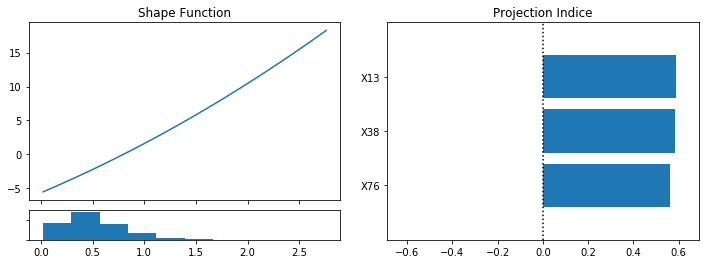

In [17]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poor.

In [18]:
clf.fit_inner_update(x, y, max_inner_iter=5, epoches=50, n_iter_no_change=1,
                     batch_size=100, val_ratio=0.2, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, verbose=True)

Inner iter: 1 epoch: 1 with validation loss: 0.46702
Inner iter: 1 epoch: 2 with validation loss: 0.46833
Inner iter: 1 epoch: 3 with validation loss: 0.46968
Inner iter: 1 epoch: 4 with validation loss: 0.46741


NameError: name 'shape_fit_' is not defined

In [ ]:
clf.visualize()

In [ ]:
from sklearn.model_selection import train_test_split


clf = SimClassifier(degree=2, knot_num=20, reg_lambda=0.2, reg_gamma=1, random_state=0)
clf.fit(x, y)

proj_mat=None
max_inner_iter=2
epoches=100
n_iter_no_change=10
batch_size=100
val_ratio=0.2
learning_rate=1e-3
beta_1=0.9
beta_2=0.999
tol=0.0001
verbose=True


n_samples = x.shape[0]
sample_weight = None
sample_weight = clf._validate_sample_weight(n_samples, sample_weight)

idx1, idx2 = train_test_split(np.arange(n_samples),test_size=val_ratio, random_state=clf.random_state)
tr_x, tr_y, val_x, val_y = x[idx1], y[idx1], x[idx2], y[idx2]

for inner_iter in range(max_inner_iter):

    m_t = 0 # moving average of the gradient
    v_t = 0 # moving average of the gradient square
    no_change = 0
    num_updates = 0
    theta_0 = clf.beta_ 
    val_loss_best = np.inf
    train_size = tr_x.shape[0]

    val_xb = np.dot(val_x, theta_0)
    val_pred = clf.shape_fit_.predict_proba(val_xb)
    val_loss = clf.shape_fit_.get_loss(val_y, val_pred, sample_weight[idx2])
    print(val_loss)
    for epoch in range(epoches):

        shuffle_index = np.arange(tr_x.shape[0])
        np.random.shuffle(shuffle_index)
        tr_x = tr_x[shuffle_index]
        tr_y = tr_y[shuffle_index]

        for iterations in range(train_size // batch_size):

            num_updates += 1
            offset = (iterations * batch_size) % train_size
            batch_xx = tr_x[offset:(offset + batch_size), :]
            batch_yy = tr_y[offset:(offset + batch_size)]
            batch_sample_weight = sample_weight[offset:(offset + batch_size)]

            xb = np.dot(batch_xx, theta_0)
            r = batch_yy - clf.shape_fit_.predict_proba(xb)

            # gradient
            dfxb = clf.shape_fit_.diff(xb, order=1)
            g_t = np.average((- dfxb * r).reshape(-1, 1) * batch_xx, axis=0,
                        weights=batch_sample_weight).reshape(-1, 1)

            # update the moving average 
            m_t = beta_1 * m_t + (1 - beta_1) * g_t
            v_t = beta_2 * v_t + (1 - beta_2) * (g_t * g_t)
            # calculates the bias-corrected estimates
            m_cap = m_t / (1 - (beta_1 ** (num_updates + 1)))  
            v_cap = v_t / (1 - (beta_2 ** (num_updates + 1)))
            # updates the parameters
            theta_0 = theta_0 - (learning_rate * m_cap) / (np.sqrt(v_cap) + 1e-8)

        # validation loss
        val_xb = np.dot(val_x, theta_0)
        val_pred = clf.shape_fit_.predict_proba(val_xb)
        val_loss = clf.shape_fit_.get_loss(val_y, val_pred, sample_weight[idx2])
        # stop criterion
        if np.abs(val_loss_best - val_loss) > tol:
            val_loss_best = val_loss
            no_change = 0
        else:
            no_change += 1
        if no_change >= n_iter_no_change:
            break
        if verbose:
            print("Inner iter:", inner_iter + 1, "epoch:", epoch + 1, "with validation loss:", np.round(val_loss, 5))

    break
#     ## thresholding and normalization
#     theta_0 = np.sign(theta_0) * np.maximum(np.abs(theta_0) - 0.1 * np.max(np.abs(theta_0)), 0)
#     if proj_mat is not None:
#         theta_0 = np.dot(proj_mat, theta_0)
#     if np.linalg.norm(theta_0) > 0:
#         theta_0 = theta_0 / np.linalg.norm(theta_0)
#     else:
#         theta_0 = theta_0

#     if len(theta_0[np.abs(theta_0) > 0]) > 0:
#         if (theta_0[np.abs(theta_0) > 0][0] < 0):
#             theta_0 = - theta_0

#     # ridge update
#     clf.beta_ = theta_0
#     xb = np.dot(x, clf.beta_)
#     clf._estimate_shape(xb, y, sample_weight, xmin=np.min(xb), xmax=np.max(xb))


In [ ]:
theta_0 = np.sign(theta_0) * np.maximum(np.abs(theta_0) - 0.1 * np.max(np.abs(theta_0)), 0)
theta_0 = theta_0 / np.linalg.norm(theta_0)

In [ ]:
clf.reg_gamma

In [ ]:
from pysim.aspline import ASplineClassifier

xb = np.dot(x, theta_0)
shape_fit_ = ASplineClassifier(knot_num=clf.knot_num, reg_gamma=0.1,
                               xmin=np.min(xb), xmax=np.max(xb), maxiter=10, maxiter_irls=100, degree=clf.degree)
shape_fit_.fit(xb, y, sample_weight)
shape_fit_.get_loss(y, shape_fit_.predict_proba(xb)), shape_fit_.selected_knots_, shape_fit_.coef_

In [ ]:
shape_fit_.visualize()

In [ ]:
roc_auc_score(y, shape_fit_.predict_proba(xb))

In [ ]:
# tempy = y.copy().astype(np.float32)
# tempy[tempy==0] = 0.01
# tempy[tempy==1] = 0.99

# selected_basis = shape_fit_._create_basis(xb, shape_fit_.degree, shape_fit_.selected_knot_vector_)

# seBWB = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), selected_basis, axes=([0], [0]))
# seBWY = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), shape_fit_._inv_link(tempy), axes=([0], [0]))
# shape_fit_.coef_ = np.dot(np.linalg.pinv(seBWB, rcond=1e-3), seBWY)
# best_loss_irls = np.inf
# for j in range(1000):
#     lp = np.dot(selected_basis, shape_fit_.coef_)
#     mu = shape_fit_._link(lp)
#     omega = mu * (1 - mu)
#     mask = (np.abs(omega) >= shape_fit_.EPS) * np.isfinite(omega)
#     mask = mask.ravel()
#     if np.sum(mask) == 0:
#         break
#     seBW = selected_basis[mask] * sample_weight[mask].reshape([-1, 1])
#     seBWOB = np.tensordot(seBW * omega[mask].reshape([-1, 1]), selected_basis[mask], axes=([0], [0]))
#     coef_temp = np.dot(np.linalg.pinv(seBWOB, rcond=1e-3), seBWOB.dot(shape_fit_.coef_) \
#                        + np.tensordot(seBW, y[mask] - mu[mask], axes=([0], [0])))
#     new_loss = shape_fit_.get_loss(y, shape_fit_._link(np.dot(selected_basis, coef_temp)), sample_weight)
#     print(j, new_loss)
#     if new_loss - best_loss_irls >= 0:
#         break
#     best_loss_irls = new_loss
#     shape_fit_.coef_ = coef_temp
# shape_fit_.coef_